In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import os

### Reading clean data

In [2]:
dspaths = []

def read_paths(dir_path):
  for dirname, _, filenames in os.walk(dir_path):
      for filename in filenames:
          if filename.endswith('.parquet'):
              pds = os.path.join(dirname, filename)
              dspaths.append(pds)
              print(pds)
  return dspaths

def read_files(dspaths):
    individual_dfs = [pd.read_parquet(dsp) for dsp in dspaths]
    return individual_dfs

In [3]:
dspaths = read_paths('../Local/2017_Clean')
dfs = read_files(dspaths)

data = pd.concat(dfs, ignore_index=True)

../Local/2017_Clean/Combined.parquet
../Local/2017_Clean/Friday-WorkingHours-Afternoon-DDos.parquet
../Local/2017_Clean/Friday-WorkingHours-Afternoon-PortScan.parquet
../Local/2017_Clean/Friday-WorkingHours-Morning.parquet
../Local/2017_Clean/Monday-WorkingHours.parquet
../Local/2017_Clean/Thursday-WorkingHours-Afternoon-Infilteration.parquet
../Local/2017_Clean/Thursday-WorkingHours-Morning-WebAttacks.parquet
../Local/2017_Clean/Tuesday-WorkingHours.parquet
../Local/2017_Clean/Wednesday-workingHours.parquet


In [4]:
data[" Label"].value_counts()

 Label
BENIGN                        4293798
DoS Hulk                       345692
DDoS                           256028
PortScan                       181388
DoS GoldenEye                   20572
FTP-Patator                     11862
DoS slowloris                   10770
DoS Slowhttptest                10456
SSH-Patator                      6438
Bot                              3896
Web Attack � Brute Force         2940
Web Attack � XSS                 1304
Infiltration                       72
Web Attack � Sql Injection         42
Heartbleed                         22
Name: count, dtype: int64

<Axes: xlabel=' Label'>

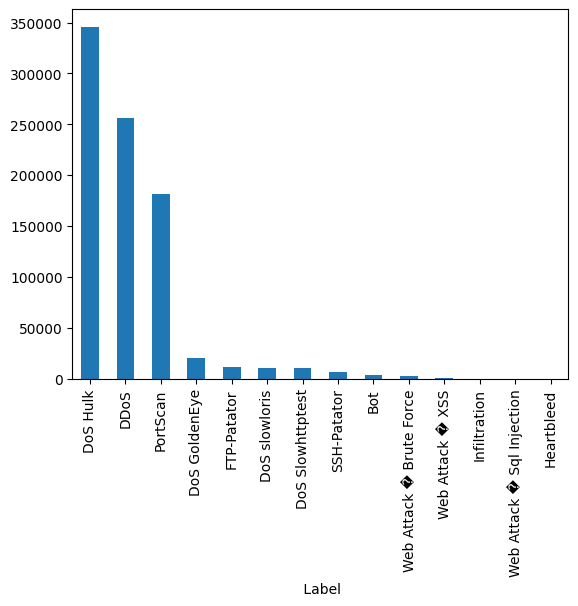

In [5]:
data[data[" Label"] != "BENIGN"][" Label"].value_counts().plot(kind='bar')

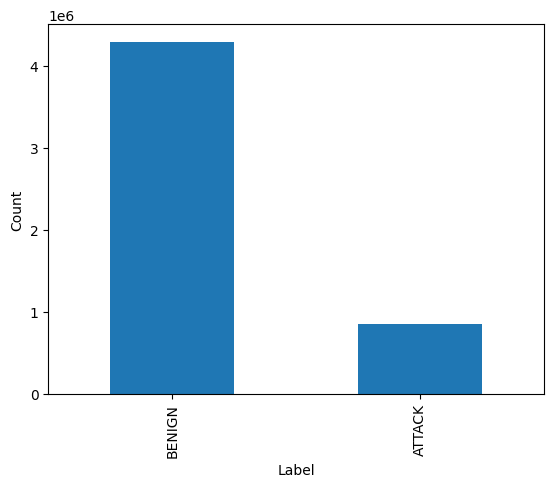

In [6]:
label_counts = data[" Label"].value_counts()
summary_counts = pd.Series({
    "BENIGN": label_counts["BENIGN"],
    "ATTACK": label_counts.drop("BENIGN").sum()
})
summary_counts.plot(kind='bar')

plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Feature importance evaluation using Random Forest

In [7]:
X = data.drop(' Label', axis=1)
y = data[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
importances = rf.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances.head(15))

                         Feature  Importance
41             Packet Length Std    0.061881
54          Avg Bwd Segment Size    0.059585
42        Packet Length Variance    0.059554
39             Max Packet Length    0.048546
13         Bwd Packet Length Std    0.040787
10         Bwd Packet Length Max    0.040694
52           Average Packet Size    0.040552
63             Subflow Fwd Bytes    0.037607
5    Total Length of Bwd Packets    0.035790
6          Fwd Packet Length Max    0.033856
65             Subflow Bwd Bytes    0.030449
4    Total Length of Fwd Packets    0.029553
12        Bwd Packet Length Mean    0.021729
53          Avg Fwd Segment Size    0.021140
62           Subflow Fwd Packets    0.020535


In [15]:
mean_importance = feature_importances['Importance'].mean()

important_features = feature_importances[feature_importances['Importance'] > mean_importance]
important_feature_names = important_features['Feature'].tolist()

X_important = X[important_feature_names]

print(important_feature_names)

[' Packet Length Std', ' Avg Bwd Segment Size', ' Packet Length Variance', ' Max Packet Length', ' Bwd Packet Length Std', 'Bwd Packet Length Max', ' Average Packet Size', ' Subflow Fwd Bytes', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Subflow Bwd Bytes', 'Total Length of Fwd Packets', ' Bwd Packet Length Mean', ' Avg Fwd Segment Size', 'Subflow Fwd Packets', ' Flow IAT Std', ' Packet Length Mean', ' Destination Port', ' Fwd IAT Max', ' PSH Flag Count', ' Total Fwd Packets', ' Fwd Header Length.1', 'Idle Mean', ' Fwd IAT Std', ' Init_Win_bytes_backward', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' act_data_pkt_fwd']


### Trimming columns according to importance

Selected two sets of features based on two different runs of RFC.

In [18]:
selected_features_1 = [
    'Label', 'Packet Length Std', 'Packet Length Variance', 'Max Packet Length', 
    'Subflow Fwd Bytes', 'Avg Bwd Segment Size', 'Destination Port', 'Average Packet Size', 
    'Bwd Packet Length Max', 'Bwd Packet Length Std', 'Init_Win_bytes_forward', 'Total Length of Bwd Packets', 
    'Total Length of Fwd Packets', 'Subflow Bwd Bytes', 'Packet Length Mean', 'Bwd Packet Length Mean'
]

selected_features_2 = [
    'Label', 'Packet Length Std', 'Avg Bwd Segment Size', 'Packet Length Variance',
    'Max Packet Length', 'Bwd Packet Length Std', 'Bwd Packet Length Max', 'Average Packet Size', 
    'Subflow Fwd Bytes', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Subflow Bwd Bytes', 
    'Total Length of Fwd Packets', 'Bwd Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Packets'
]

data.columns = data.columns.str.strip()

new_data_1 = data[selected_features_1]
new_data_2 = data[selected_features_2]

new_data_1.to_parquet("../Local/2017_Final/Combined_1.parquet", index=False)
new_data_2.to_parquet("../Local/2017_Final/Combined_2.parquet", index=False)